In [1]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pylab as plt

%matplotlib inline

np.set_printoptions(precision=3, linewidth=150, suppress=True)
np.random.seed(799)

On va augmenter le rayon de convergence la méthode Jacobi amméliorée faite en TD à savoir la méthode de Gauss-Seidel.

On étudiera sa convergence dans différents cas.

## Gauss-Seidel

Lorsqu'on calcul le **x** suivant avec Jacobi on ne profite pas du fait que N est triangulaire
et donc qu'on connait la nouvelle valeur de $x_n$ lorsqu'on calcule $x_{n-1}$. Avec Gauss-Seidel
on utilise toujours la dernière valeur calculée ce qui accélère la convergence.

Pour résumer Gauss-Seidel d'un point de vu matriciel on a :

* D = la matrice diagonale extraite de A : `D = np.diag(np.diag(A))`
* L = la matrice stritecement triangulaire inférieure de A : `L = np.tril(A, -1)`
* U = la matrice stritecement triangulaire supérieure de A : `U = np.triu(A, 1)`

et une itération est donnée par la formule suivante :

$$
(D + L)\, {\bf x}^{k+1} = -U\; {\bf x}^k + {\bf b}
$$
ou
$$
{\bf x}^{k+1} = D^{-1} \, ( -L\, {\bf x}^{k+1} - U\; {\bf x}^k + {\bf b})
$$

c.a.d.

$$
\begin{bmatrix}
x_{1}^{k+1} \\
x_{2}^{k+1} \\
\vdots \\
x_{n}^{k+1} 
\end{bmatrix}
=
\begin{bmatrix}
1/a_{11} \quad 0 \quad \ldots \quad 0 \\
0 \quad 1/a_{22} \quad \ldots \quad 0 \\
 \vdots \\
0 \quad 0  \quad \ldots \quad 1/a_{nn} 
\end{bmatrix}
\;
\left(
\;
-
\begin{bmatrix}
0 \quad 0 \quad \ldots \quad 0 \\
a_{21} \; 0 \quad \ldots \quad 0 \\
 \vdots \\
a_{n1} \, a_{n2}  \; \ldots \quad 0
\end{bmatrix}
\;
\begin{bmatrix}
x_{1}^{k+1} \\
x_{2}^{k+1} \\
\vdots \\
x_{n}^{k+1}
\end{bmatrix}
-
\begin{bmatrix}
0 \; a_{12} \; \ldots \; a_{1n} \\
0 \quad 0 \; \ldots \; a_{2n}  \\
 \vdots \\
0 \quad 0  \; \ldots \; 0
\end{bmatrix}
\;
\begin{bmatrix}
x_{1}^k \\
x_{2}^k \\
\vdots \\
x_{n}^k 
\end{bmatrix}
+
\begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{n} 
\end{bmatrix}
\; \right)
$$

Notons que je peux mettre $L\, {\bf x}^{k+1}$ à droite du signe égal
si je résoud mon système ligne par ligne en commencant par le haut puisque dans
ce cas les ${\bf x}^{k+1}$ utilisés sont connus. C'est ce qu'on a fait lors du dernier TP.


### Surrelaxation de Gauss-Seidel

Comme on a fait avec Jacobi, on introduit une inertie avec $w$ :

$$
{\bf x}^{k+1} = w \, D^{-1} \, ( -L\, {\bf x}^{k+1} - U\; {\bf x}^k + {\bf b}) + (1-w) \; {\bf x}^k
$$

Vérifiez que l'on arrive à l'écriture matricielle suivante :

$$
\left(\frac{D}{w} + L\right)\, {\bf x}^{k+1} = \left(\frac{1-w}{w} \, D - U\right)\; {\bf x}^k + {\bf b}
$$

Écrit ainsi on voit que cette méthode consiste à avoir les éléments de la diagonale des 2 cotés de l'égalité.
On peut interpréter cela comme un avantage lié à un gain d'information lors des opérations matrice vecteur.

### Programmons Gauss-Seidel surrelaxé

On écrira deux fonctions :

* `solve_triangular(L,b)` qui retourne la solution de L **x** = **b** lorsque L est triangulaire inférieure
* `gauss_seidel_r(A, b, x0, w, n)` qui fait `n` iteration de Gauss-Seidel avec `w` donné en argument à partir
   de `x0`.
   Cette fonction retourne un tableau des valeurs de **x** calculées (donc tableau en 2D).
   
Comme toujours, attention à limiter les `for` et à faire le plus possible d'opérations vectorielles et matricielles.

In [2]:
def solve_triangular(L, b):
    x = np.empty(len(b))
    x[0] = b[0] / L[0,0]
    for i in range(1,len(L)):
        x[i] = (b[i] - L[i,:i] @ x[:i]) / L[i,i]
    return x
            
# je teste            
A = np.tril(np.random.randint(10, size=(4,4)))
b = A.sum(axis=1)
solve_triangular(A,b)

array([1., 1., 1., 1.])

In [3]:
def gauss_seidel_r(A, b, x0, w=0.5, n=100):
    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    L = D / w + L
    U = ((1-w) / w) * D - U
    x = x0
    values = []
    for _ in range(n):
        x = solve_triangular(L, U @ x + b)
        values.append(x)
    return np.array(values)

In [4]:
np.random.seed(123)
A = np.random.randint(10, size=(4,4))
b = A.sum(axis=1)
x0 = np.random.random(4)
print(A)
res = gauss_seidel_r(A, b, x0, w=0.2, n=100)
print(res[-1])

[[2 2 6 1]
 [3 9 6 1]
 [0 1 9 0]
 [0 9 3 4]]
[1. 1. 1. 1.]


In [5]:
def plot_convergences(values, result):
    error = np.square(values - result).sum(axis = -1) / np.square(result).sum(axis=-1)
    error2 = np.square(np.diff(values)).sum(axis = -1) / np.square(values).sum(axis=-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    ax1.plot(range(len(error)), error)
    ax1.set_title('Erreur absolue normalisée')
    ax1.semilogy();
    ax2.plot(range(len(error2)), error2)
    ax2.set_title('Erreur relative normalisée')
    ax2.semilogy()
    print("Itération du minimum :",np.argmin(error), np.argmin(error2))

Itération du minimum : 99 99


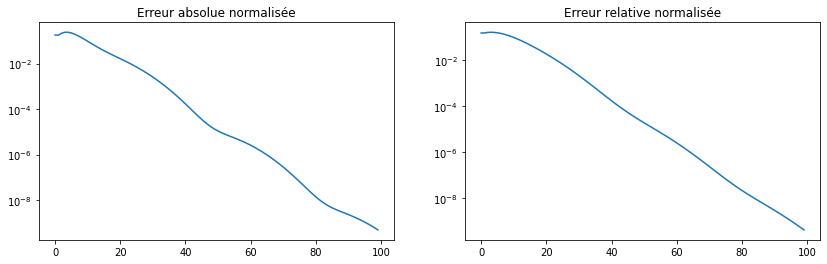

In [6]:
plot_convergences(res, np.ones(4))

Notez que le même exemple ne converge pas avec Jacobi + inertie.

Est-ce que la méthode de Gauss-Seidel non relaxée converge dans ce cas ?

In [7]:
gauss_seidel_r(A, b, x0, w=1, n=100)[-1]  # oui

array([1., 1., 1., 1.])

### Le bon cas

Trouver un `seed` qui permet de générer un cas qui ne converge pas avec Gauss-Seidel de base mais qui 
converge avec la relaxation ($w=0.2$).

In [8]:
seed = 0
while True:
    np.random.seed(seed)
    A = np.random.randint(10, size=(4,4))
    b = A.sum(axis=1)
    x0 = np.random.random(4)

    res = gauss_seidel_r(A, b, x0, w=0.2, n=100)
    res2 = gauss_seidel_r(A, b, x0, w=1, n=100)
    if np.square(res[-1] - np.ones(4)).sum() < 0.01 and np.square(res2[-1] - np.ones(4)).sum() > 1 :
        print(seed)
        break
    seed += 1

<ipython-input-2-5766c8b312a0>:5: RuntimeWarning: divide by zero encountered in double_scalars
  x[i] = (b[i] - L[i,:i] @ x[:i]) / L[i,i]
<ipython-input-2-5766c8b312a0>:5: RuntimeWarning: invalid value encountered in matmul
  x[i] = (b[i] - L[i,:i] @ x[:i]) / L[i,i]
<ipython-input-3-c8e2ca06153d>:10: RuntimeWarning: invalid value encountered in matmul
  x = solve_triangular(L, U @ x + b)
<ipython-input-2-5766c8b312a0>:5: RuntimeWarning: invalid value encountered in double_scalars
  x[i] = (b[i] - L[i,:i] @ x[:i]) / L[i,i]
<ipython-input-2-5766c8b312a0>:3: RuntimeWarning: divide by zero encountered in double_scalars
  x[0] = b[0] / L[0,0]


87


Tracer les courbes de convergence pour le cas retenu avec et sans relaxation.

In [9]:
np.random.seed(87)
A = np.random.randint(10, size=(4,4))
b = A.sum(axis=1)
x0 = np.random.random(4)

Itération du minimum : 95 97


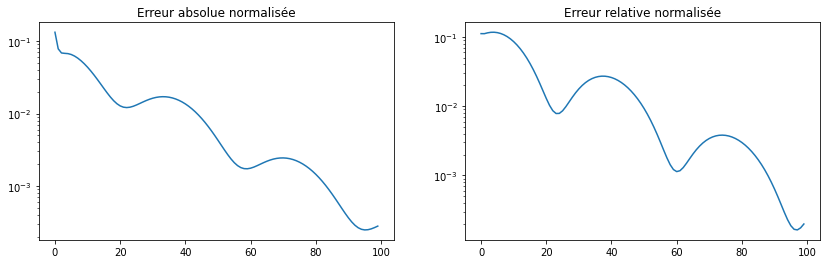

In [10]:
plot_convergences(gauss_seidel_r(A, b, x0, w=0.2, n=100), np.ones(4))

Itération du minimum : 0 0


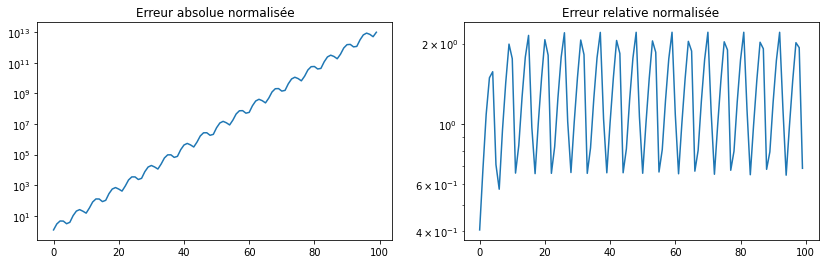

In [11]:
plot_convergences(gauss_seidel_r(A, b, x0, w=1, n=100), np.ones(4))

### Étude de $w$

Toujours dans notre cas retenu,
indiquer quel est l'intervale de
valeurs de $w$ qui garantit la convergence pour notre système matriciel A **x** = **b** avec toujours le même `x0` 
et un nombre d'itérations à déterminer.

Trouver la valeur optimiale de $w$ pour converger le plus rapidement pour ce cas. 

La précision demandée pour l'intervale et la valeur optimale est de $10^{-2}$.

In [12]:
# utilisons une méthode par dichotomie
wmin = 0
wmax = 1
while wmax - wmin > 1E-2:
    w = (wmax + wmin) / 2
    res = gauss_seidel_r(A,b,x0, w, n=1000)[-1]
    if np.square(res - np.ones(4)).sum(axis=-1) < 1E-3:  # converge
        wmin = w
    else:  
        wmax = w
print(f"Intervale de convergence : ]0,{(wmin+wmax)/2}]")

Intervale de convergence : ]0,0.69140625]


Itération du minimum : 493 494


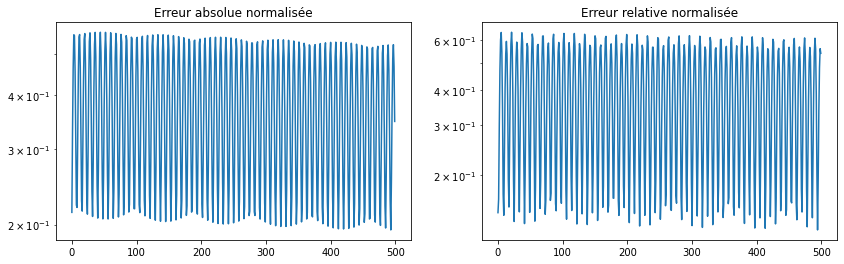

In [13]:
plot_convergences(gauss_seidel_r(A, b, x0, w=0.7, n=500), np.ones(4)) # ca converge tres doucement

Itération du minimum : 0 0


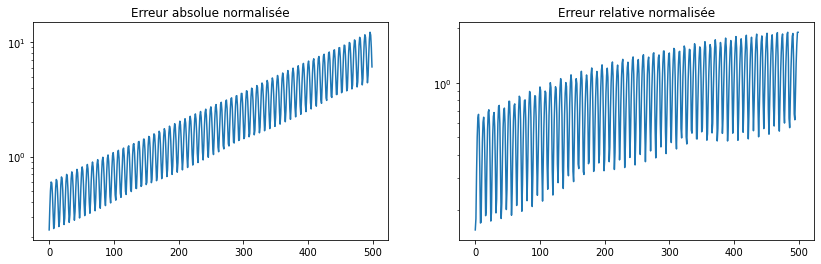

In [14]:
plot_convergences(gauss_seidel_r(A, b, x0, w=0.7 + 1E-2, n=500), np.ones(4)) # ca diverge clairement

Il semble que $w = 0.7$ soit la limite de la convergence.

Trouvons la valeur optimale de $w$ à savoir celle qui permet la convergence la plus rapide.

In [15]:
# ce tableau nous montre la décroissance de l'erreur pour chaque valeur de la solution
np.square(gauss_seidel_r(A, b, x0, 0.5, 500) - np.ones(4))

array([[0.072, 0.045, 0.07 , 0.004],
       [0.152, 0.006, 0.032, 0.029],
       [0.134, 0.001, 0.018, 0.087],
       ...,
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ]])

En ne filtrant avec `< 1E-6` j'obtiens un tableau de booléens et avec `argmax` je récupère l'indice de la première ligne avec 4 `True` :

In [16]:
# Méthode brutale (Newton serait plus joli mais je ne sais pas si vous connaissez)
# de toute facon c'est très rapide

N = 500
best_w = 0
best_it = N

for i in np.arange(0.01, 0.7, 0.01):
    it_cv = np.argmax(np.square(gauss_seidel_r(A, b, x0, i, 500) - np.ones(4)).sum(axis=-1) < 1E-6) 
    # attention, si la réponse est 0 cela veut dire que cela n'est pas descendu en dessous de 1E-6
    if it_cv > 0 and it_cv < best_it:
        best_w = i
        best_it = it_cv
best_w, best_it

(0.36000000000000004, 154)

Itération du minimum : 99 99


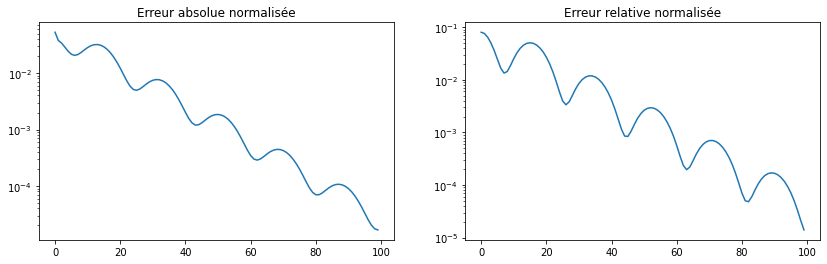

In [17]:
plot_convergences(gauss_seidel_r(A, b, x0, w=0.36, n=100), np.ones(4))

Trouver la valeur optimale de $w$ doit bien sûr pouvoir être fait rapidement. Pour certains problèmes particulier
on connait la formule qui donne le $w$ optimal, sinon il faut utiliser des heuristiques sans garanties.